# SET ENVIRONMENT

In [1]:
# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM)', os.getcwd())[0]
sys.path.append(root_project)

In [39]:
import pandas as pd
from src.features.add_features import add_features
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.models import  Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib 
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner import Objective
import keras
from livelossplot import PlotLossesKeras
from src.utils.help_func import rename_indicators
import eli5
from eli5.sklearn import PermutationImportance

import pickle
sns.set()

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11584360895681692483
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8382277933659189101
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6440927904
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11266558593914551698
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6486394629018243935
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
seed = 42
df_raw = pd.read_csv("../../data/processed/simulation_results_REV4.csv")
df_raw.head()

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
0,DJI,12.187967,1.733278,21.125133,0.197944,2.160967e+03,4757.961648,4.063839e+04,0.067606,0.353545,0.487118,3.178464,6190.5,19,20,3.023155e+09,2.439964e+09,5.834951e+08
1,KAZ,8.802094,0.776828,6.837709,0.886055,2.402667e+02,907.398367,1.574797e+03,0.000394,0.687708,2.763238,4.812301,1111.5,11,8,1.828206e+09,1.569210e+09,2.590006e+08
2,LTU,12.787478,0.195316,2.497605,0.113979,2.503724e+08,7666.911039,1.304820e+06,2692.626822,0.221513,1232.088915,0.284607,305603.0,13,15,7.511292e+09,1.664463e+09,5.846913e+09
3,DMA,16.545501,1.022406,16.916222,0.104739,1.404241e+05,50184.583240,1.678547e+06,58.666486,0.378172,0.890632,1.590765,180539.5,13,10,4.906761e+09,3.136703e+09,1.770351e+09
4,CPV,10.116505,2.062013,20.860369,0.129716,1.649600e+03,2644.412518,3.383422e+04,0.091010,0.278977,0.358051,2.099191,3457.5,8,5,5.049934e+09,3.687545e+09,1.362756e+09


In [5]:
df = add_features(df_raw)
df = rename_indicators(df)

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df = df.loc[df['total_deceased'] > 1 ]
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(47005, 39)
(44836, 39)


In [7]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population',
    ]

df = df[features]
df.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population
0,10.612469,-2.694055,7.678311,8.467575,8.730771,-1.039743,-0.719250,1.156398,19,20,-6.821070,-2.569464,0.426104,13.773563,6.638568,19.800943,0.323896
1,7.361881,-7.838180,5.481749,6.810582,7.013466,-0.374391,1.016403,1.571175,11,8,-7.093339,-1.531476,0.449393,16.721127,10.240924,22.010951,0.208307
2,14.081576,7.898273,19.338460,8.944669,12.630042,-1.507273,7.116466,-1.256645,13,15,-8.981960,-1.451434,0.448485,14.841385,8.723719,20.436248,0.220952
3,14.333439,4.071869,11.852422,10.823463,12.103705,-0.972406,-0.115824,0.464215,13,10,-7.675671,-2.763620,0.323615,11.181751,6.643790,15.157147,0.416386
4,10.429228,-2.396791,7.408288,7.880204,8.148301,-1.276627,-1.027080,0.741552,8,5,-5.465003,-2.070473,0.462500,13.206276,7.631917,20.600119,0.489508


In [8]:
df.isna().sum()

ind_1.1                   0
ind_1.2                   0
ind_1.3                   0
ind_1.4                   0
ind_2.1                   0
ind_2.2                   0
ind_2.3                   0
ind_2.4                   0
n_closed                  0
react_time                0
betweenness_log           0
degree_log                0
closeness                 0
country_pop_log           0
country_departures_log    0
exposed_pop_log           0
affected_population       0
dtype: int64

# DATA PREPARATION

In [9]:
X = df.drop('affected_population', axis=1)
y = df['affected_population']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state=seed)

In [10]:
def ResultsRegressorCV(scores):
    print(f"R2: {scores['test_r2'].mean()}, {scores['test_r2'].std()}")
    print(f"MAE: {-scores['test_neg_mean_absolute_error'].mean()}, {scores['test_neg_mean_absolute_error'].std()}")
    print(f"RMSE: {-scores['test_neg_root_mean_squared_error'].mean()}, {scores['test_neg_root_mean_squared_error'].std()}")
    return None

def make_scores(d_score, model_name):
    try:
        df = pd.read_pickle('scores_models.pkl')
        df[model_name] = list(d_score.values())
        df.to_pickle('scores_models.pkl')
    except:
        s = pd.Series(d_score)
        s.name = model_name
        df = pd.DataFrame(s)
        df.to_pickle('scores_models.pkl')
        
def coeff_determination(y_true, y_pred):
    """
    Implements the coefficient of determination to be used in a Keras model.

    Parameters
    ----------
    y_true : np.array
        Ground truth.
    y_pred : np.array
        Predictions.

    Returns
    -------
    float
        Coefficient of determination.

    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# MODEL

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_val_scaled = scaler.transform(X_val.astype(np.float64))

In [12]:
tf.keras.backend.clear_session()

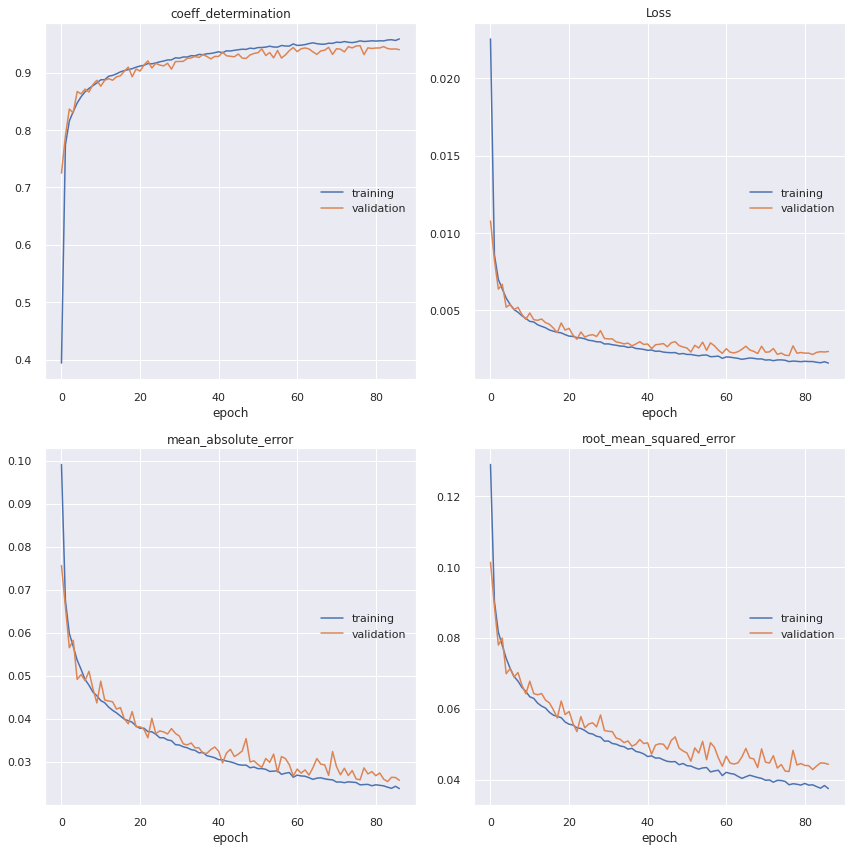

coeff_determination
	training         	 (min:    0.394, max:    0.959, cur:    0.959)
	validation       	 (min:    0.725, max:    0.947, cur:    0.940)
Loss
	training         	 (min:    0.002, max:    0.023, cur:    0.002)
	validation       	 (min:    0.002, max:    0.011, cur:    0.002)
mean_absolute_error
	training         	 (min:    0.024, max:    0.099, cur:    0.024)
	validation       	 (min:    0.025, max:    0.076, cur:    0.026)
root_mean_squared_error
	training         	 (min:    0.037, max:    0.129, cur:    0.037)
	validation       	 (min:    0.042, max:    0.101, cur:    0.044)


In [13]:
inputs = Input(shape=X_train_scaled.shape[1:])
h0 = Dense(32, activation='selu', kernel_initializer='lecun_normal')(inputs)
h1 = Dense(32, activation='selu', kernel_initializer='lecun_normal')(h0)
h2 = Dense(32, activation='selu', kernel_initializer='lecun_normal')(h1)
h3 = Dense(32, activation='selu', kernel_initializer='lecun_normal')(h2)
h4 = Dense(32, activation='selu', kernel_initializer='lecun_normal')(h3)
h5 = Dense(16, activation='selu', kernel_initializer='lecun_normal')(h4)
preds = Dense(1)(h5)

early_stopping_cb = EarlyStopping(
                            patience=10, restore_best_weights=True)

model = Model(inputs=inputs, outputs=preds)
sgd = Nadam()
model.compile(optimizer=sgd, loss='mean_squared_error',
              metrics=[
                'mean_absolute_error',
                root_mean_squared_error,
                coeff_determination])

history = model.fit(X_train_scaled, y_train, epochs=500, verbose=0,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[PlotLossesKeras(), early_stopping_cb]) 


score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
score_test = model.evaluate(X_val_scaled, y_val, verbose=0) 

In [14]:
print(f"Train scores: {score_train}")
print(f"Validation scores: {score_test}")

Train scores: [0.0015062106540426612, 0.023488188162446022, 0.0366789735853672, 0.9599042534828186]
Validation scores: [0.0020785899832844734, 0.02582843229174614, 0.04231075942516327, 0.9467261433601379]


In [15]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=X_train_scaled.shape[1:]))
    units=hp.Int('units_layer', min_value=16, max_value=128, step=16)
        
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=units,
                               activation='selu',
                               kernel_initializer='lecun_normal'))
    model.add(Dense(1))
    model.compile(
        optimizer=Nadam(),
        loss='mean_squared_error',
        metrics=[
                'mean_absolute_error',
                'mean_absolute_percentage_error',
                coeff_determination])
    
    return model

tuner = RandomSearch(
    build_model,
    objective=Objective('val_coeff_determination', direction='max'),
    max_trials=20,
    executions_per_trial=2,
    directory='nn_trials',
    project_name='pandemic')

tuner.search_space_summary()

early_stopping_cb = EarlyStopping(
                            patience=10, restore_best_weights=True)

# Uncomment netxt lines to train the models
tuner.search(X_train_scaled, y_train,
            epochs=500,
            validation_data=(X_val_scaled, y_val),
            callbacks=[early_stopping_cb],
             verbose=0)

INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()

In [ ]:
tf.keras.backend.clear_session()

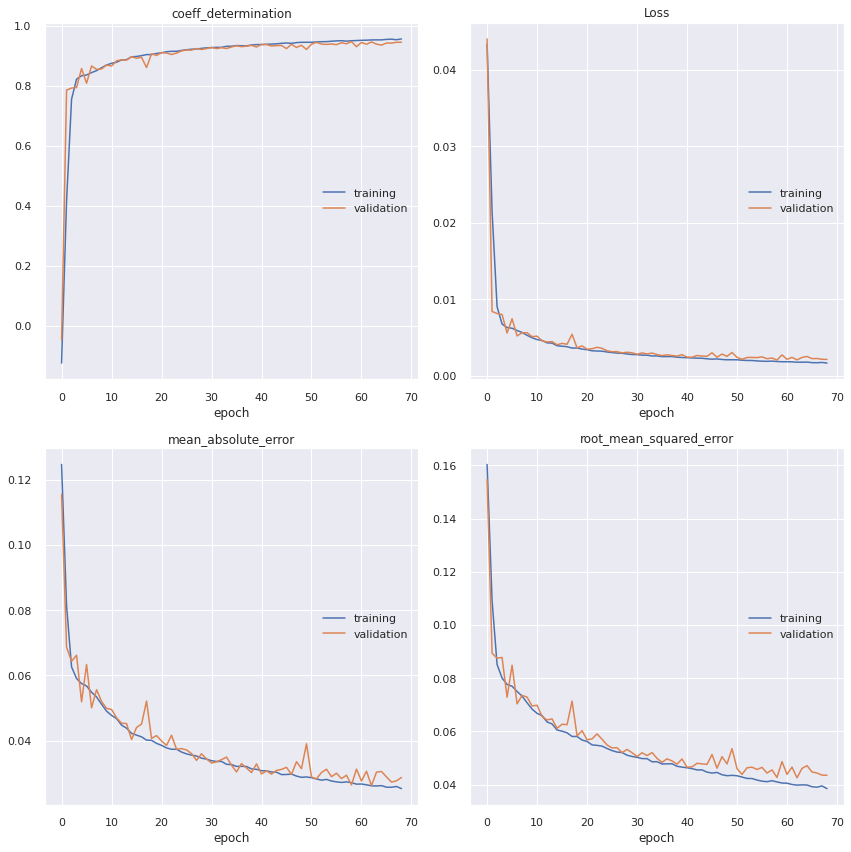

coeff_determination
	training         	 (min:   -0.125, max:    0.957, cur:    0.957)
	validation       	 (min:   -0.048, max:    0.948, cur:    0.946)
Loss
	training         	 (min:    0.002, max:    0.043, cur:    0.002)
	validation       	 (min:    0.002, max:    0.044, cur:    0.002)
mean_absolute_error
	training         	 (min:    0.025, max:    0.125, cur:    0.025)
	validation       	 (min:    0.026, max:    0.116, cur:    0.029)
root_mean_squared_error
	training         	 (min:    0.038, max:    0.160, cur:    0.038)
	validation       	 (min:    0.043, max:    0.155, cur:    0.043)


In [17]:
inputs = Input(shape=X_train_scaled.shape[1:])
h0 = Dense(80, activation='selu', kernel_initializer='lecun_normal')(inputs)
h1 = Dense(80, activation='selu', kernel_initializer='lecun_normal')(h0)
h2 = Dense(80, activation='selu', kernel_initializer='lecun_normal')(h1)
h3 = Dense(80, activation='selu', kernel_initializer='lecun_normal')(h2)
preds = Dense(1)(h3)

early_stopping_cb = EarlyStopping(
                            patience=10, restore_best_weights=True)

model = Model(inputs=inputs, outputs=preds)
sgd = Nadam()
model.compile(optimizer=sgd, loss='mean_squared_error',
              metrics=[
                'mean_absolute_error',
                root_mean_squared_error,
                coeff_determination])

history = model.fit(X_train_scaled, y_train, epochs=500, verbose=0,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[PlotLossesKeras(), early_stopping_cb]) 


score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
score_test = model.evaluate(X_val_scaled, y_val, verbose=0) 

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 80)                1360      
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 81        
Total params: 20,881
Trainable params: 20,881
Non-trainable params: 0
_________________________________________________________

In [20]:
y_pred = model.predict(X_val_scaled)
r2_score(y_val, y_pred)

0.9500535222779545

In [19]:
# model.save('models/neural_network.h5')
model = keras.models.load_model('models/neural_network.h5')

In [45]:
perm = PermutationImportance(model, n_iter=10, scoring='r2', random_state=seed).fit(X_val_scaled,y_val)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.9720 ± 0.0210,ind_2.4
0.7623 ± 0.0117,ind_1.3
0.7607 ± 0.0267,ind_1.2
0.4168 ± 0.0073,ind_2.3
0.2676 ± 0.0117,degree_log
0.2561 ± 0.0069,ind_1.4
0.2545 ± 0.0070,n_closed
0.2001 ± 0.0089,ind_2.1
0.1248 ± 0.0045,ind_2.2
0.1165 ± 0.0062,country_departures_log


# TEST SET

In [55]:
df_test = pd.read_csv('../../data/processed/simulation_results_REV4_test.csv')
df_test

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
0,MRT,6.957955,1.712730,11.917101,0.421474,5.200000e+00,8.642633e+00,2.391741e+01,0.000035,0.717949,4.460011,4.170287,9.5,11,20,1.128905e+06,9.414420e+05,1.873230e+05
1,CRI,10.071858,1.993278,20.076016,0.256798,8.853333e+01,2.085479e+02,1.121798e+03,0.000531,0.508660,1.089355,4.263092,240.0,18,16,2.215812e+09,1.856075e+09,3.600110e+08
2,DNK,13.220658,2.176956,28.780786,0.556694,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,9,12,1.000000e+00,0.000000e+00,0.000000e+00
3,GRC,10.596798,0.878435,9.308599,0.953062,4.333333e+00,8.490222e+00,1.022128e+01,0.000012,0.823077,9.969037,7.228118,8.0,10,20,4.477377e+08,4.023809e+08,4.534857e+07
4,FIN,7.026326,2.165711,15.216989,0.433996,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,9,18,1.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,PLW,15.000192,1.136469,17.047250,0.062791,1.058593e+05,9.130263e+04,3.299506e+06,176.353732,0.074554,0.049978,0.621937,118502.5,11,18,5.120920e+09,2.647732e+09,2.473577e+09
7996,GUM,15.249274,1.770462,26.998260,0.327660,9.250000e+01,2.244101e+02,1.052011e+03,0.016740,0.581622,1.391915,7.305558,288.0,13,10,3.000256e+09,2.695716e+09,3.047204e+08
7997,OMN,10.832344,1.294841,14.026168,0.455143,2.284667e+02,7.268619e+02,2.398521e+03,0.001419,0.589145,1.485245,5.108631,876.5,11,9,2.862542e+09,2.474888e+09,3.876690e+08
7998,NCL,13.829648,0.589161,8.147894,0.098775,8.396607e+06,1.930275e+06,1.220615e+08,886.778145,0.261722,0.367218,0.696197,7306416.5,14,7,4.966547e+09,2.214751e+09,2.751913e+09


In [56]:
df_test = add_features(df_test)
df_test = rename_indicators(df_test)

invalid value encountered in log


In [57]:
df_test = df_test.loc[df_test['total_deceased'] > 1 ]
print(df_test.shape)
df_test.dropna(inplace=True)
print(df_test.shape)

(5436, 39)
(5185, 39)


In [58]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population',
    ]

df_test = df_test[features]
df_test.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population
0,3.174607,-10.248013,1.648659,2.156707,2.251292,-0.331357,1.495151,1.427985,11,20,-9.989554,-2.763620,0.402904,15.297869,6.858565,19.156177,0.000125
1,7.022688,-7.540260,4.483379,5.340169,5.480639,-0.675976,0.085586,1.449995,18,16,-8.073405,-2.224624,0.408088,15.424837,7.991931,20.327708,0.246387
3,2.324472,-11.320802,1.466337,2.138915,2.079442,-0.194706,2.299484,1.977979,10,20,-6.129009,-0.971861,0.504545,16.188337,9.990124,20.978504,0.053415
5,17.296856,7.314873,19.338513,11.886407,15.410504,-1.486454,4.059960,-1.224325,0,14,-8.073405,-2.224624,0.408088,15.424837,7.991931,20.327708,0.227000
7,18.732431,8.647402,16.166950,14.393026,16.057403,-1.978746,-1.026244,-1.220580,18,7,-36.043653,-4.709530,0.383420,10.920745,7.980024,19.605983,0.011278


In [59]:
X_test = df.drop('affected_population', axis=1)
y_test = df['affected_population']

In [60]:
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [61]:
model.evaluate(X_test_scaled, y_test)

1402/1402 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0358 - coeff_determination: 0.964 - ETA: 2s - loss: 0.0019 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0414 - coeff_determination: 0.952 - ETA: 3s - loss: 0.0019 - mean_absolute_error: 0.0256 - root_mean_squared_error: 0.0417 - coeff_determination: 0.952 - ETA: 2s - loss: 0.0018 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0405 - coeff_determination: 0.951 - ETA: 2s - loss: 0.0017 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0399 - coeff_determination: 0.953 - ETA: 2s - loss: 0.0017 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0392 - coeff_determination: 0.955 - ETA: 2s - loss: 0.0016 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0385 - coeff_determination: 0.956 - ETA: 2s - loss: 0.0016 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0383 - coeff_determination: 0.957 - ETA: 2s - l

[0.001641289098188281,
 0.02449168637394905,
 0.03842581436038017,
 0.9564163088798523]

In [81]:
def plot_predictions(y_test, y_predicted, samples=20):

    df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
    df_predicted.sample(samples).plot(kind='barh', figsize=(10, 15))
    plt.title('Neural Network Sampled Predictions', fontsize=20)
    plt.xlabel('Affected Population [%]')
    plt.ylabel('Index label')
    plt.show()
    return None

In [82]:
y_pred = model.predict(X_test_scaled)

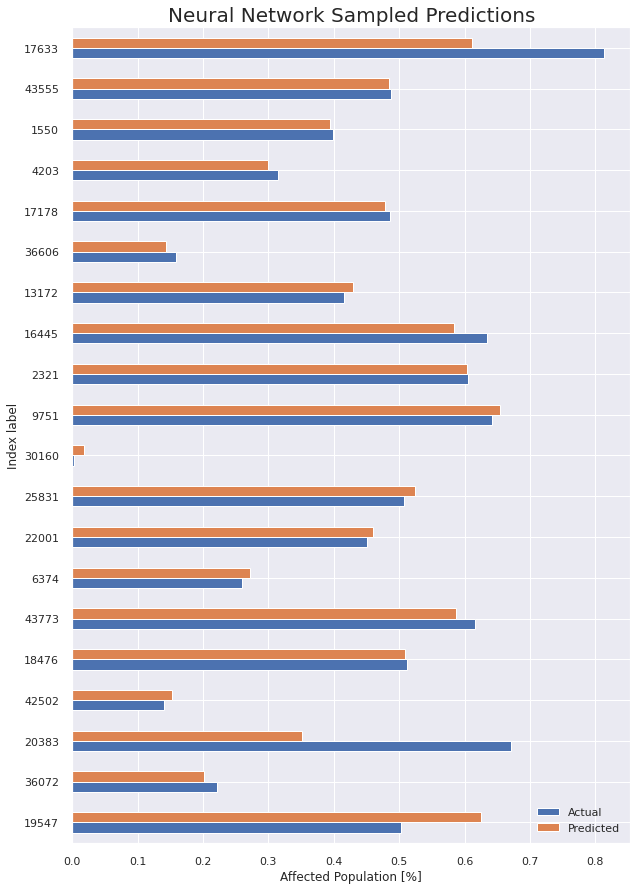

In [84]:
plot_predictions(y_test.reset_index(drop=True), y_pred.flatten(), samples=20)